In [1]:
from google.colab import files
files.upload()   # upload kaggle.json here


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rehank88","key":"43d41ca95cdbb0256fc09592e7ce998f"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [3]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip -q chest-xray-pneumonia.zip


Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
 96% 2.20G/2.29G [00:19<00:02, 41.1MB/s]
100% 2.29G/2.29G [00:19<00:00, 124MB/s] 


In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report
import cv2


In [5]:
DATA_DIR = "chest_xray"
IMG_SIZE = (224, 224)
BATCH_SIZE = 16

train_path = os.path.join(DATA_DIR, "train")
val_path   = os.path.join(DATA_DIR, "val")
test_path  = os.path.join(DATA_DIR, "test")

train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.15,
    horizontal_flip=True
).flow_from_directory(
    train_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary"
)

val_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    val_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=False
)

test_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    test_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=False
)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


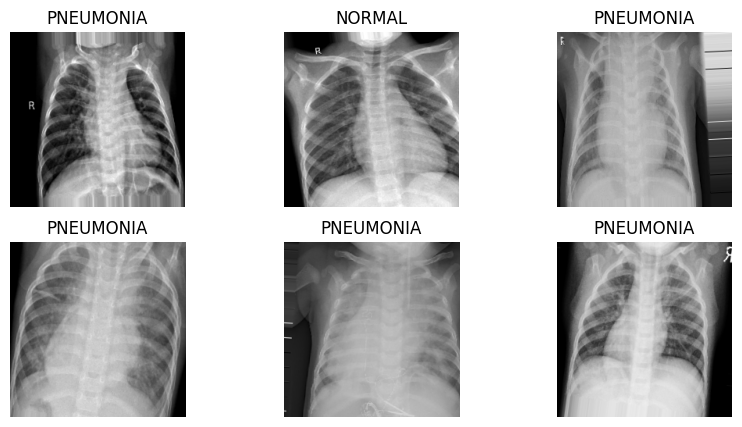

In [6]:
x, y = next(train_gen)
plt.figure(figsize=(10,5))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(x[i])
    plt.title("PNEUMONIA" if y[i] == 1 else "NORMAL")
    plt.axis("off")
plt.show()


In [7]:
base_model = MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

base_model.trainable = False  # freeze initial layers

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.3)(x)
output = Dense(1, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [8]:
checkpoint = ModelCheckpoint(
    "best_model.h5",
    monitor="val_accuracy",
    save_best_only=True,
    mode="max"
)

early = EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor="val_loss", patience=2, factor=0.5)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=[checkpoint, early, reduce_lr]
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 541ms/step - accuracy: 0.7713 - loss: 0.4907

326/326 ━━━━━━━━━━━━━━━━━━━━ 183s 548ms/step - accuracy: 0.7715 - loss: 0.4903 - val_accuracy: 0.9375 - val_loss: 0.3124 - learning_rate: 1.0000e-04
Epoch 2/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 170s 520ms/step - accuracy: 0.8963 - loss: 0.2378 - val_accuracy: 0.9375 - val_loss: 0.3356 - learning_rate: 1.0000e-04
Epoch 3/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 182s 557ms/step - accuracy: 0.9235 - loss: 0.1910 - val_accuracy: 0.6875 - val_loss: 0.4182 - learning_rate: 1.0000e-04
Epoch 4/10
  2/326 ━━━━━━━━━━━━━━━━━━━━ 2:56 544ms/step - accuracy: 0.9844 - loss: 0.0673

KeyboardInterrupt: 

In [9]:
base_model.trainable = True  # unfreeze all layers

for layer in base_model.layers[:100]:
    layer.trainable = False  # keep lower layers frozen

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

history_ft = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=2,
    callbacks=[checkpoint, early, reduce_lr]
)


Epoch 1/2
326/326 ━━━━━━━━━━━━━━━━━━━━ 301s 886ms/step - accuracy: 0.8622 - loss: 0.3271 - val_accuracy: 0.5625 - val_loss: 1.3036 - learning_rate: 1.0000e-05
Epoch 2/2
326/326 ━━━━━━━━━━━━━━━━━━━━ 267s 817ms/step - accuracy: 0.9218 - loss: 0.1803 - val_accuracy: 0.5625 - val_loss: 1.2780 - learning_rate: 1.0000e-05


In [10]:
def plot_history(h):
    plt.figure(figsize=(12,5))

    # ACCURACY
    plt.subplot(1,2,1)
    plt.plot(h.history['accuracy'], label="Train Acc")
    plt.plot(h.history['val_accuracy'], label="Val Acc")
    plt.title("Accuracy")
    plt.legend()

    # LOSS
    plt.subplot(1,2,2)
    plt.plot(h.history['loss'], label="Train Loss")
    plt.plot(h.history['val_loss'], label="Val Loss")
    plt.title("Loss")
    plt.legend()

    plt.show()

plot_history(history)
plot_history(history_ft)


NameError: name 'history' is not defined

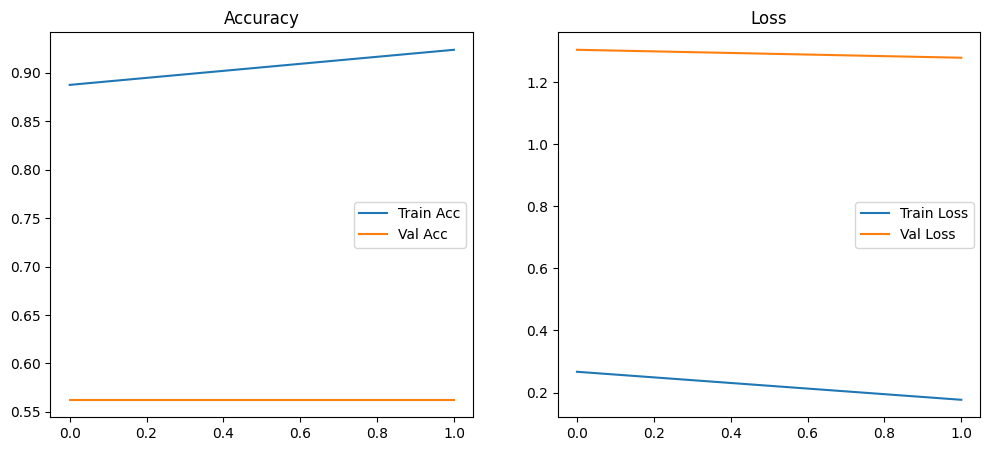

In [11]:
plot_history(history_ft)

In [12]:
model = tf.keras.models.load_model("best_model.h5")

preds = model.predict(test_gen)
y_pred = (preds > 0.5).astype("int").flatten()
y_true = test_gen.classes

print(classification_report(y_true, y_pred, target_names=["Normal", "Pneumonia"]))


39/39 ━━━━━━━━━━━━━━━━━━━━ 25s 572ms/step
              precision    recall  f1-score   support

      Normal       0.92      0.68      0.79       234
   Pneumonia       0.84      0.97      0.90       390

    accuracy                           0.86       624
   macro avg       0.88      0.83      0.84       624
weighted avg       0.87      0.86      0.86       624



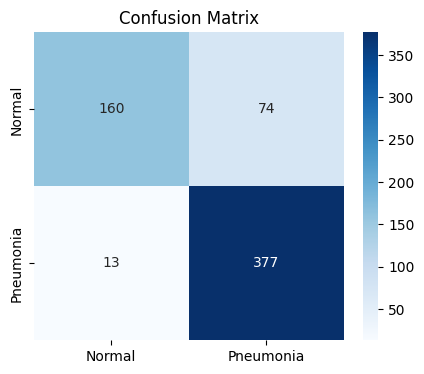

In [13]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Normal", "Pneumonia"],
            yticklabels=["Normal", "Pneumonia"])
plt.title("Confusion Matrix")
plt.show()


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


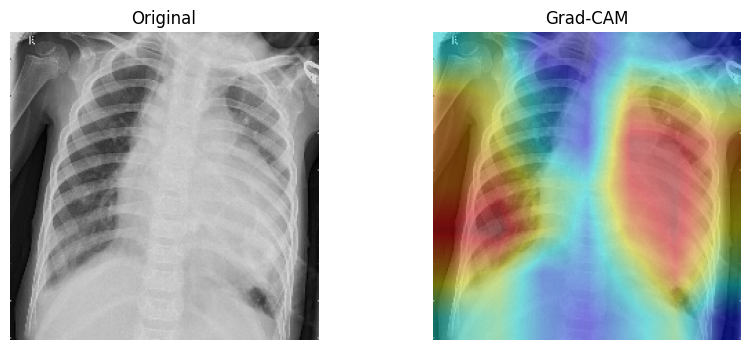

In [14]:
def get_gradcam(model, img_array, layer_name="Conv_1"):
    grad_model = Model([model.inputs],
                       [model.get_layer(layer_name).output, model.output])

    with tf.GradientTape() as tape:
        conv_outputs, preds = grad_model(img_array)
        loss = preds[:, 0]

    grads = tape.gradient(loss, conv_outputs)
    weights = tf.reduce_mean(grads, axis=(1,2))
    cam = tf.reduce_sum(tf.multiply(weights, conv_outputs), axis=-1).numpy()[0]
    cam = np.maximum(cam, 0)
    cam = cam / cam.max()
    return cam

def show_gradcam(img_path):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=IMG_SIZE)
    img_array = tf.keras.preprocessing.image.img_to_array(img)/255.0
    img_array = np.expand_dims(img_array, axis=0)

    heatmap = get_gradcam(model, img_array)
    heatmap = cv2.resize(heatmap, (224, 224))

    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    orig = cv2.imread(img_path)
    orig = cv2.resize(orig, (224, 224))

    superimposed = cv2.addWeighted(orig, 0.6, heatmap_color, 0.4, 0)

    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1); plt.title("Original"); plt.imshow(orig[...,::-1]); plt.axis("off")
    plt.subplot(1,2,2); plt.title("Grad-CAM"); plt.imshow(superimposed[...,::-1]); plt.axis("off")
    plt.show()

example_img = test_path + "/PNEUMONIA/" + os.listdir(test_path + "/PNEUMONIA")[0]
show_gradcam(example_img)


In [15]:
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt

IMG_SIZE = (224, 224)

# Load your best model
model = tf.keras.models.load_model("best_model.h5")

def predict_pneumonia(img_path):
    # Load image
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=IMG_SIZE)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Prediction
    prediction = model.predict(img_array)[0][0]

    # Result
    if prediction > 0.5:
        label = "PNEUMONIA"
        confidence = prediction
    else:
        label = "NORMAL"
        confidence = 1 - prediction

    # Display result
    plt.imshow(img)
    plt.title(f"Prediction: {label} ({confidence*100:.2f}%)")
    plt.axis("off")
    plt.show()

    return label, confidence


In [16]:
from google.colab import files
uploaded = files.upload()


Saving xray1.jpeg to xray1.jpeg


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


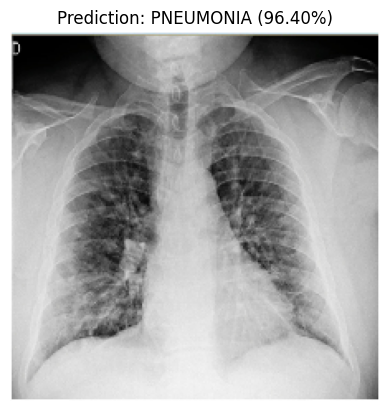

('PNEUMONIA', np.float32(0.9640349))

In [17]:
predict_pneumonia("xray1.jpeg")


In [18]:
from google.colab import files
uploaded = files.upload()

Saving xray2.jpeg to xray2.jpeg


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


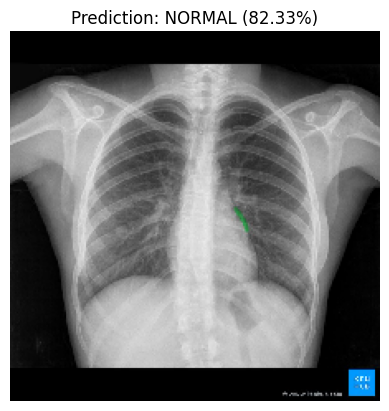

('NORMAL', np.float32(0.8233338))

In [19]:
predict_pneumonia("xray2.jpeg")

In [20]:
model.save("pneumonia_detector.h5")
model.save("pneumonia_detector_savedmodel")


ValueError: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=pneumonia_detector_savedmodel.

In [21]:
model.save("pneumonia_detector.keras")


In [22]:
from google.colab import files
files.download("pneumonia_detector.keras")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>